In [1]:
#from libs.prefect_helpers import *
from libs.data_manipulation import *
from libs.feature_generation import *
from libs.dim_reduction import *
from libs.football_plots import *
from libs.clustering import *
from libs.convex_hull import *

import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree
from libs.InteractivePitchUI import InteractivePitch, PitchDisplay

from mplsoccer import *
import pandas as pd
import numpy as np
import os
# Click player into the pitch and take those player and apply Ripleys K to them. And then maybe PCA


/home/martin/.local/lib/python3.10/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.2.3) or chardet (None)/charset_normalizer (2.1.0) doesn't match a supported version!
  warnings.warn(


In [2]:
# Step 1: Extract match data from tracking data
data = compile_team_tracking_data("data", "England")
one_match = extract_one_match(data, 4)


In [3]:
print(np.unique(one_match['match_name']))

['Denmark_England' 'England_Slovakia' 'England_Slovenia'
 'England_Switzerland']


In [4]:
import os
import json
import re
import numpy as np
import pandas as pd
from libs.Video_Player import *

def extract_metadata(file_path):
    """Load and return data from a JSON file."""
    with open(file_path, "r", encoding="utf-8") as f:
        return json.load(f)

def extract_half_start(data):
    """Extract and convert start times of the first and second half into seconds."""
    first_half_start = data["halvesTimestamps"]["1H"]["startTime"]
    second_half_start = data["halvesTimestamps"]["2H"]["startTime"]
    first_half_end = data["halvesTimestamps"]["1H"]["endTime"]

    # Convert HH:MM:SS to total seconds
    def time_to_seconds(time_str):
        h, m, s = map(int, time_str.split(":"))
        return h * 3600 + m * 60 + s

    return time_to_seconds(first_half_start), time_to_seconds(second_half_start), time_to_seconds(first_half_end)

def find_files(match_folder):
    """Finds the .json and .mp4 files in the match folder."""
    json_file, video_file = None, None

    for file in os.listdir(match_folder):
        if file.endswith(".json"):
            json_file = os.path.join(match_folder, file)
        elif file.endswith(".mp4"):
            video_file = os.path.join(match_folder, file)

    if not json_file or not video_file:
        raise FileNotFoundError("Required .json or .mp4 file missing in the folder.")

    return json_file, video_file

def find_match_folder(tournament_folder, match_name):
    """
    Finds the correct match folder inside the tournament folder.
    Match folders contain numbers (e.g., '2036178_Denmark_England'),
    so we search for a folder that contains 'match_name'.
    """
    for folder in os.listdir(tournament_folder):
        if match_name in folder:
            return os.path.join(tournament_folder, folder)
    
    raise FileNotFoundError(f"Match folder for '{match_name}' not found in '{tournament_folder}'")

def process_match_data(tournament_folder, raw_match_name):
    """
    Given the tournament folder and match name from the DataFrame,
    locate the correct match folder, extract halves' start times, and find the video.
    """
    match_folder = find_match_folder(tournament_folder, raw_match_name)
    
    # Find JSON and MP4 files dynamically
    json_file, video_file = find_files(match_folder)

    # Extract data from JSON
    data = extract_metadata(json_file)
    first_half_start, second_half_start, first_half_end = extract_half_start(data)

    return {
        "match_folder": match_folder,
        "json_file": json_file,
        "video_file": video_file,
        "first_half_start": first_half_start,
        "second_half_start": second_half_start,
        "first_half_end" : first_half_end
    }

# **Optimized function to process only unique match names**
def process_dataframe(df, tournament_folder):
    """Processes each unique match in the DataFrame to extract JSON and video details."""
    results = []
    
    unique_match_names = df['match_name'].drop_duplicates().tolist()  # Extract unique match names

    for match_name in unique_match_names:
        print(f"Processing match: {match_name}")
        try:
            match_data = process_match_data(tournament_folder, match_name)
            results.append(match_data)
            # Append the match name to results
            results[-1]["match_name"] = match_name
        except FileNotFoundError as e:
            print(f"Error processing match {match_name}: {e}")
    return pd.DataFrame(results)

# Example usage:
tournament_folder = "data/H_EURO2024GERMANY"

processed_data = process_dataframe(one_match, tournament_folder)

def display_match_info(df):
    """Displays match information in a structured format."""
    if df.empty:
        print("No valid match data found.")
        return

    print("\n=========== Processed Match Data ===========")
    
    for i, row in df.iterrows():
        print(f"\nMatch Folder: {row['match_folder']}")
        print(f"Folder Name: {os.path.basename(row['match_folder'])}\n")
        print(f"Match Name: {row['match_name']}\n")

        print(f"JSON File: {row['json_file']}")
        print(f"JSON Name: {os.path.basename(row['json_file'])}\n")

        print(f"Video File: {row['video_file']}")
        print(f"Video Name: {os.path.basename(row['video_file'])}\n")

        print(f"First Half Start: {row['first_half_start']} seconds")
        print(f"Second Half Start: {row['second_half_start']} seconds")
        print("=" * 50)  # Separator line

# Example usage:
display_match_info(processed_data)

# Extracting video details for playback
#for _, row in processed_data.iterrows():
#    video_file = row["video_file"]
#    video_name = os.path.basename(video_file)
#    first_half_start = row["first_half_start"]
#    second_half_start = row["second_half_start"]
#    print(second_half_start)
#    example_indices = np.array([[0, '1H'], [0, '2H']])#

#    # Launch Video Player
#    VideoPlayer(video_file, video_name, first_half_start, second_half_start, example_indices)
#    

Processing match: Denmark_England
Error processing match Denmark_England: [Errno 2] No such file or directory: 'data/H_EURO2024GERMANY'
Processing match: England_Slovenia
Error processing match England_Slovenia: [Errno 2] No such file or directory: 'data/H_EURO2024GERMANY'
Processing match: England_Slovakia
Error processing match England_Slovakia: [Errno 2] No such file or directory: 'data/H_EURO2024GERMANY'
Processing match: England_Switzerland
Error processing match England_Switzerland: [Errno 2] No such file or directory: 'data/H_EURO2024GERMANY'
No valid match data found.


In [5]:
print(processed_data.columns)

Index([], dtype='object')


In [6]:
def show_reccomendations(processed_video_info, match_data : pd.DataFrame, indices):
    relevant_rows = match_data.loc[indices]
    print(relevant_rows)
    
    for index, data in relevant_rows.iterrows():
        print(data)

        meta_data = processed_video_info[processed_video_info["match_name"] == data['match_name']].iloc[0]
        
      
        indices = [data[["Time [s]","half"]].to_numpy()]
        print(indices)
        video_file = meta_data["video_file"]
        print(meta_data['video_file'])
        video_name = os.path.basename(video_file)
        first_half_start = meta_data["first_half_start"]
        second_half_start = meta_data["second_half_start"]
        first_half_end = meta_data["first_half_end"]
        if (video_name):
            VideoPlayer(video_file, video_name, first_half_start,first_half_end, second_half_start, indices)
    



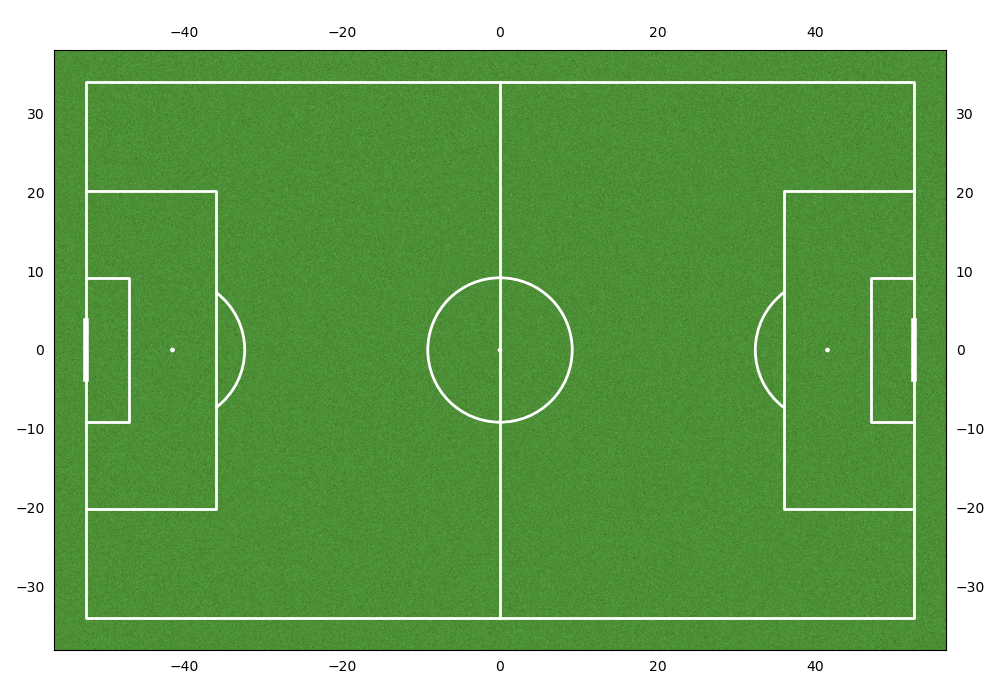

13932
144516
2
2
13932
Starting length calculation
12899
Wasserstein calculated, closest situations: [144516, 196644, 144564, 791124, 681348, 700980, 225444, 238836, 701028, 700932]
Sequence length 50
[144516, 196644, 480084, 604068, 153396, 519636, 196692, 276948, 577572, 789204]


In [7]:

%matplotlib widget


interactive_pitch = InteractivePitch(one_match)


In [8]:
show_reccomendations(processed_data, interactive_pitch.match_data, interactive_pitch.similar_situation_indices[:5])

Empty DataFrame
Columns: [match_id, Time [s], Time [s]_team, half_team, minute_team, Period_team, home_6_x, home_6_y, home_1_x, home_1_y, home_10_x, home_10_y, home_11_x, home_11_y, home_2_x, home_2_y, home_7_x, home_7_y, home_8_x, home_8_y, home_9_x, home_9_y, home_5_x, home_5_y, home_12_x, home_12_y, home_4_x, home_4_y, home_20_x, home_20_y, home_16_x, home_16_y, home_26_x, home_26_y, ball_z_team, half, minute, Period, away_2_x, away_2_y, away_22_x, away_22_y, away_7_x, away_7_y, away_9_x, away_9_y, away_1_x, away_1_y, away_25_x, away_25_y, away_14_x, away_14_y, away_20_x, away_20_y, away_11_x, away_11_y, away_13_x, away_13_y, away_6_x, away_6_y, away_26_x, away_26_y, away_10_x, away_10_y, away_17_x, away_17_y, away_8_x, away_8_y, ball_x, ball_y, ball_z, match_name, home_19_x, home_19_y, home_21_x, home_21_y, away_3_x, away_3_y, away_5_x, away_5_y, away_21_x, away_21_y, away_23_x, away_23_y, away_19_x, away_19_y, away_18_x, away_18_y, away_15_x, away_15_y, home_18_x, home_18_y, home_